# Introduction

Import Libraries

In [1]:
import urllib.request
from urllib.request import urlopen

import sys
import spotipy
import spotipy.util as util
import os
import json
import webbrowser
from json.decoder import JSONDecodeError

In [2]:
import pandas as pd
import numpy as np

from scipy import stats

from sklearn.linear_model import LinearRegression
lr = LinearRegression()
from numpy import arange,array,ones
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
import seaborn as sns

# Set font scale
sns.set(font_scale=1.5)

import itertools

from scipy import optimize
from scipy.optimize import minimize

from gekko import gekko

Expand Screen

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Load Data

In [9]:
import json
# Import by Github
#link = 'https://raw.githubusercontent.com/dqa611/Spotify_DJ/master/anhquocduong611_Anjunadeep_playlist_data.json'
#with urlopen(link) as f:
#    playlist_data = json.load(f)

# Import by local
local_address = 'C:/Users/anhqu/OneDrive/Desktop/QAs/QA github folder/anhquocduong611_Trance_playlist_data.json'
with open(local_address) as json_file:
    playlist_data = json.load(json_file)

In [11]:
#username_x = link[59:]
username_x = 'anhquocduong611'
#username_y = username_x.index('_')
username = username_x

# Playlist name from link
#playlist_name = str(link[link.index(username) + len(username)+1:link.index('_playlist')])
# Playlist name from local
playlist_name = str(local_address[local_address.index(username) + len(username)+1:local_address.index('_playlist')])
print('Playlist name: ')
print(playlist_name)

Playlist name: 
Trance


# Bobdy Script

### Get Summary Statistics about the Playlist

In [12]:
audio_data_point = ['track_name', 'duration_ms', 'popularity', 'danceability', 
                    'energy', 'key', 'mode', 'loudness', 'speechiness', 'acousticness', 
                    'instrumentalness', 'liveness', 'valence', 'tempo',]

playlist_stats = dict.fromkeys(audio_data_point)

for data_point in audio_data_point:
    audio_stats = []
    for i in range(len(playlist_data)):
        audio_stats.append(playlist_data[i][data_point])
        playlist_stats[data_point] = audio_stats

In [13]:
data_point_plot = ['popularity', 'danceability', 'energy', 'loudness', 'speechiness', 'valence', 'tempo']
data_point_comb = list(itertools.combinations(data_point_plot, r=2))

#### More information about the data points

https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/

### Playlist Data Point Distribution

In [14]:
def hist_plot():
    print('Green line is average line')
    print('Red line is median line')
    fig = plt.figure(figsize=(30,30))
    fig.subplots_adjust(hspace=0.8, wspace=0.8)
    for i in range(len(data_point_plot)):

        ax = fig.add_subplot(6,6,i+1)
        ax = sns.distplot(playlist_stats[data_point_plot[i]], bins='auto')

        # Draw average line
        ax.axvline(pd.DataFrame(playlist_stats[data_point_plot[i]]).mean().item(), color='green', linestyle='dashed', linewidth=1)
        # Draw median line
        ax.axvline(pd.DataFrame(playlist_stats[data_point_plot[i]]).median().item(), color='red', linestyle='dashed', linewidth=1)

        ax.set_xlabel(data_point_plot[i], color='tomato')
        ax.tick_params(axis='x', colors='tomato')
        ax.tick_params(axis='y', colors='tomato')
    return plt

Green line is average line
Red line is median line
<module 'matplotlib.pyplot' from 'C:\\Users\\anhqu\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>


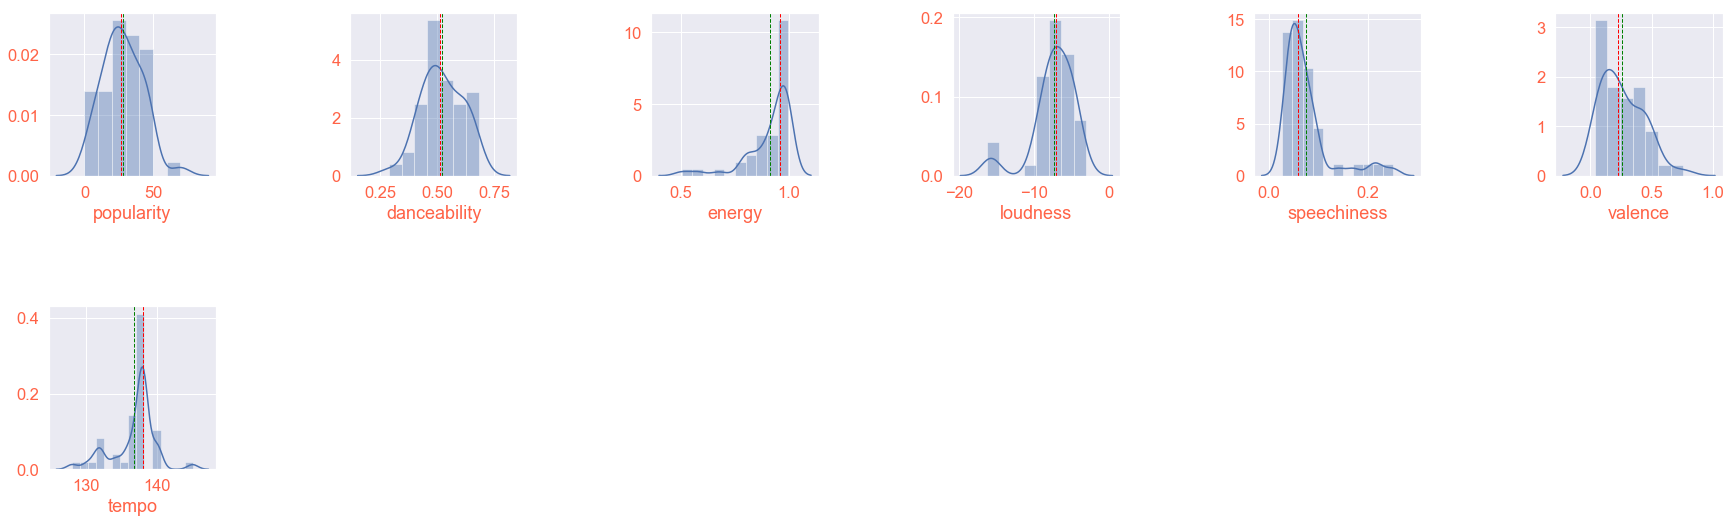

In [15]:
print(hist_plot())

### Plot a Track by Sections

###### Convert duration from seconds to minute

In [16]:
for i in range(len(playlist_data)):
    for z in range(len(playlist_data[i]['sections'])):
        playlist_data[i]['sections'][z]['start_minute'] = playlist_data[i]['sections'][z]['start']/60

In [17]:
track_metrics = ['start_minute', 'loudness', 'tempo', 'mode']
track_metrics_dict = dict.fromkeys(track_metrics, 0)
all_tracks_sections = []

track_metrics_dict1 = track_metrics_dict.copy()

for x in range(len(playlist_data)):
    track_metrics_dict1['track_name'] = playlist_data[x]['track_name']
    track_metrics_dict1['track_id'] = playlist_data[x]['track_id']
    track_metrics_dict1['artist'] = playlist_data[x]['artist']
    track_metrics_dict1['album'] = playlist_data[x]['album']
    # For each metric
    for y in track_metrics:
        # Reset the list that collects data point 
        track_sections_data = []        
        # For each metric, loop by the number of sections in the track
        for z in range(len(playlist_data[x]['sections'])):
            # Add data point to a list
            track_sections_data.append(playlist_data[x]['sections'][z][y])
            # Add the list to a dict of track data points
            track_metrics_dict1[y] = track_sections_data
    # Add the dict to a list of tracks
    all_tracks_sections.append(track_metrics_dict1.copy())

###### Function to plot a Track

Writer's opinion: a homogeneous playlist will have normal distributions among Data Points

### Correlation Between Data Points in the Playlist

In [18]:
def corre_plot():
    fig = plt.figure(figsize=(30,30))
    fig.subplots_adjust(hspace=0.8, wspace=0.8)

    for i in range(len(data_point_comb)):
        ax = fig.add_subplot(8,8,i+1)
        ax = sns.regplot(playlist_stats[data_point_comb[i][0]], playlist_stats[data_point_comb[i][1]])
        ax.set_xlabel(data_point_comb[i][0], color='tomato')
        ax.set_ylabel(data_point_comb[i][1], color='tomato')
        ax.tick_params(axis='x', colors='tomato')
        ax.tick_params(axis='y', colors='tomato')
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\anhqu\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>


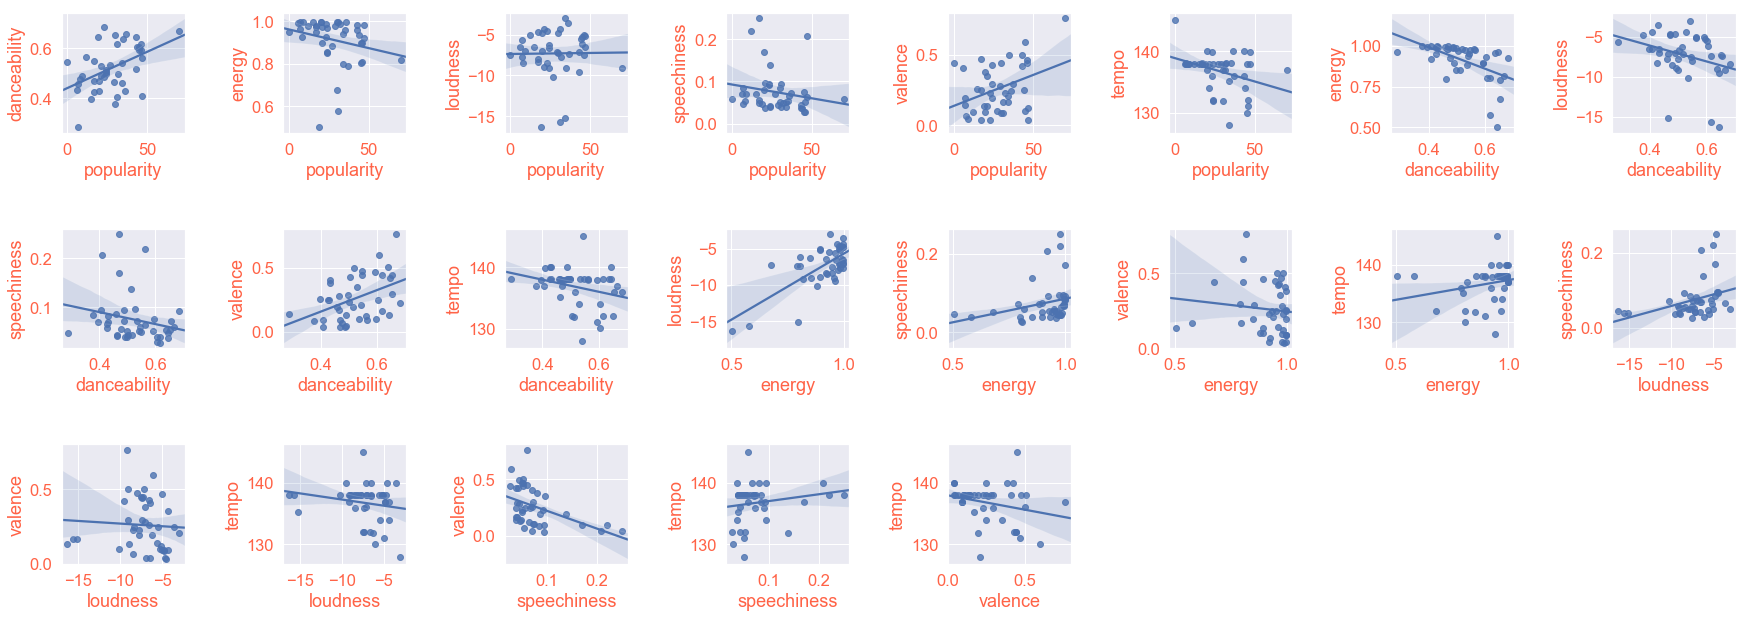

In [19]:
print(corre_plot())

In [20]:
def plot_track(track_id):
    for i in range(len(playlist_data)):
        if playlist_data[i]['track_id'] == track_id:
            track_index = i
    
    fig = plt.figure(figsize=(5,3))
    fig.subplots_adjust(hspace=0.8, wspace=0.8)
    # Plot title by Track name and Artist
    fig.suptitle(all_tracks_sections[track_index]['track_name'] + ' -- ' + all_tracks_sections[track_index]['artist'], color='tomato', fontsize=20)

    for key, value in enumerate(track_metrics[1:3]):
        ax = fig.add_subplot(2,1,key+1)
        ax = sns.lineplot(all_tracks_sections[track_index]['start_minute'], all_tracks_sections[track_index][value])
        ax.set_ylabel(value, color='tomato', fontsize=18)
        ax.tick_params(axis='x', colors='tomato')
        ax.tick_params(axis='y', colors='tomato')
        # Plot average line
        ax.axhline(np.mean(all_tracks_sections[track_index][value]), color='green', linestyle='dashed', linewidth=1)
        # Plot Section breakout line
        for i in range(len(all_tracks_sections[track_index]['start_minute'])):
            ax.axvline(all_tracks_sections[track_index]['start_minute'][i], color='purple', linestyle='dashed', linewidth=1)

    ax.set_xlabel('time', color='tomato')
    # ax.text(1, 1, 'Green line is Average \n Purple line is Section', transform=ax.transAxes, fontsize=14,verticalalignment='bottom', color='tomato')

### Create new data points

In [21]:
for i in range(len(playlist_data)):
    # Duration of 1st Section
    playlist_data[i]['duration_1st_section'] = playlist_data[i]['sections'][0]['duration']
    # Duration of last Section
    playlist_data[i]['duration_last_section'] = playlist_data[i]['sections'][len(playlist_data[i]['sections'])-1]['duration']
   
    # Tempo of 1st Section
    playlist_data[i]['tempo_1st_section'] = playlist_data[i]['sections'][0]['tempo']
    # Tempo of last Section
    playlist_data[i]['tempo_last_section'] = playlist_data[i]['sections'][len(playlist_data[i]['sections'])-1]['tempo']  
    
    # Key of 1st Section
    playlist_data[i]['key_1st_section'] = playlist_data[i]['sections'][0]['key']
    # Key of last Section
    playlist_data[i]['key_last_section'] = playlist_data[i]['sections'][len(playlist_data[i]['sections'])-1]['key']   
    
    # Modality of 1st Section
    playlist_data[i]['modality_1st_section'] = playlist_data[i]['sections'][0]['mode']
    # Modality of last Section
    playlist_data[i]['modality_last_section'] = playlist_data[i]['sections'][len(playlist_data[i]['sections'])-1]['mode']
   
    # Tempo of 2nd Section
    playlist_data[i]['tempo_2nd_section'] = playlist_data[i]['sections'][1]['tempo']
    # Tempo of 2nd last Section
    playlist_data[i]['tempo_2ndlast_section'] = playlist_data[i]['sections'][len(playlist_data[i]['sections'])-2]['tempo']  
    
    # Key of 2nd Section
    playlist_data[i]['key_2nd_section'] = playlist_data[i]['sections'][1]['key']
    # Key of 2nd last Section
    playlist_data[i]['key_2ndlast_section'] = playlist_data[i]['sections'][len(playlist_data[i]['sections'])-2]['key']     
    
    # Modality of 2nd Section
    playlist_data[i]['modality_2nd_section'] = playlist_data[i]['sections'][1]['mode']
    # Modality of 2nd last Section
    playlist_data[i]['modality_2ndlast_section'] = playlist_data[i]['sections'][len(playlist_data[i]['sections'])-2]['mode']
    
    # Loudness of 2nd Section
    playlist_data[i]['loudness_2nd_section'] = playlist_data[i]['sections'][1]['loudness']
    # Loudness of 2nd last Section
    playlist_data[i]['loudness_2ndlast_section'] = playlist_data[i]['sections'][len(playlist_data[i]['sections'])-2]['loudness']

So the goal is the ending of the previous track last second will end at the end of the first section of the next track plus 1 second

In [22]:
track_transition_data = ['duration_1st_section','duration_1st_section','duration_1st_section','duration_1st_section','tempo_1st_section','tempo_last_section',
                        'key_1st_section','key_last_section','modality_1st_section','modality_last_section','loudness_1st_section','loudness_last_section',
                        'tempo_2nd_section','tempo_2ndlast_section','key_2nd_section','key_2ndlast_section','loudness_2nd_section','loudness_2ndlast_section']

In [23]:
def track_playlist_index(track_id):
    for i in range(len(playlist_data)):
        if playlist_data[i]['track_id'] == track_id:
            track_index = i
            return track_index
            break
    print('Not Found')

### Optimization: Find the perfect next track

### Functions to Select the Best Track

1 - Harmonic keys

2 - Tempo

3 - Energy level

4 - Valence level

5 - Danceability level

6 - Popularity level

### Camelot Key Harmony Mixing

Camelot Key is a techinque to select a track that sounds harmonically well with the previous track

https://www.reddit.com/r/Beatmatch/comments/1q1pbo/the_rules_of_harmonic_mixing/

In [24]:
def get_list_info(dataset, data_point):
    data_point_list = [dataset[i][data_point] for i in range(len(dataset))]
    return data_point_list

In [25]:
def track_keys_input(track_id):
    track_keys = dict.fromkeys(['key', 'mode'])
    track_keys.update(key=playlist_data[track_playlist_index(track_id)]['key'])
    track_keys.update(mode=playlist_data[track_playlist_index(track_id)]['mode'])
    return track_keys

In [26]:
def camelot_system(track_keys):
    harmonic_keys = dict.fromkeys(['key', 'mode'])
    # Stay in the same key 4A 4A
    same_key = harmonic_keys.copy() 
    same_key['key'] = track_keys['key']
    same_key['mode'] = track_keys['mode']
    same_key_list = ['same_key', same_key]
    
    # Move up one 4A 5A
    one_key_up = harmonic_keys.copy()
    one_key_up['key'] = track_keys['key']+1 if track_keys['key']!= 12 else 1
    one_key_up['mode'] = track_keys['mode']
    one_key_up_list = ['one_key_up', one_key_up]
    
    # Move down one 4A 3A
    one_key_down = harmonic_keys.copy()
    one_key_down['key'] = track_keys['key']-1 if track_keys['key']!= 1 else 12
    one_key_down['mode'] = track_keys['mode']
    one_key_down_list = ['one_key_down', one_key_down]
    
    # Move major 4A 4B
    change_major = harmonic_keys.copy()
    change_major['key'] = track_keys['key']
    change_major['mode'] = abs(track_keys['mode']-1)
    change_major_list = ['change_major', change_major]
    
    # Move major +3 4A 7B
    change_major_3 = harmonic_keys.copy()
    change_major_3['key'] = track_keys['key']+3 if track_keys['key']<10 else track_keys['key']-9
    change_major_3['mode'] = abs(track_keys['mode']-1)
    change_major_3_list = ['change_major_3', change_major_3]
    
    # Move up minor -3 4A 1A
    up_minor_3 = harmonic_keys.copy()
    up_minor_3['key'] = track_keys['key']-3 if track_keys['key']>4 else track_keys['key']+9
    up_minor_3['mode'] = track_keys['mode']
    up_minor_3_list = ['up_minor_3', up_minor_3]
    
    # Half step 4A 11A
    half_step = harmonic_keys.copy()
    half_step['key'] = track_keys['key']+7 if track_keys['key']<6 else track_keys['key']-5
    half_step['mode'] = track_keys['mode']
    half_step_list = ['half_step', half_step]
    
    # Whole step 4A 6A
    whole_step = harmonic_keys.copy()
    whole_step['key'] = track_keys['key']+2 if track_keys['key']<11 else track_keys['key']-10
    whole_step['mode'] = track_keys['mode']
    whole_step_list = ['whole_step', whole_step]
    
    # Domniant key 4A 5B
    dominant_key = harmonic_keys.copy()
    dominant_key['key'] = track_keys['key']+1 if track_keys['key']!=12 else 1
    dominant_key['mode'] = abs(track_keys['mode']-1)
    dominant_key_list = ['dominant_key', dominant_key]
    
    harmonic_keys_list = [same_key_list, one_key_up_list, one_key_down_list, change_major_list, change_major_3_list, up_minor_3_list, half_step_list, whole_step_list, dominant_key_list]
    return harmonic_keys_list

In [27]:
def camelot_explained(key_name, mode):
    if key_name == 'same_key':
        return 'same emotion'
   
    if key_name == 'one_key_up':
        return 'raise energy'
    
    if key_name == 'one_key_down':
        return 'same emotion'
    
    if key_name == 'change_major' and mode == 0:
        return 'brighten'
    if key_name == 'change_major' and mode == 1:
        return 'darken'
    
    if key_name == 'change_major_3' and mode == 0:
        return 'brighten'
    if key_name == 'change_major_3' and mode == 1:
        return 'darken'
    
    if key_name == 'up_minor_3':
        return 'raise energy'
    
    if key_name == 'half_step':
        return 'raise energy'
    
    if key_name == 'whole_step':
        return 'raise energy'
    
    if key_name == 'dominant_key' and mode == 0:
        return 'brighten'
    
    if key_name == 'dominant_key' and mode == 1:
       return 'darken'

In [28]:
def harmonic_tracks(track_index):
    # Apply Camelot Function to get harmonic keys
    camelot_raw = camelot_system(track_keys_input(playlist_data[track_index]['track_id']))
    camelot_list = [camelot_raw[i][1] for i in range(len(camelot_raw))]
    tracks = []
    for y in range(len(playlist_data)):
        if track_keys_input(playlist_data[y]['track_id']) in camelot_list:
            for i in range(len(camelot_raw)):
                if playlist_data[y]['key'] == camelot_raw[i][1]['key'] and playlist_data[y]['mode'] == camelot_raw[i][1]['mode']:
                    tracks.append((playlist_data[y]['track_id'],
                                   playlist_data[y]['track_name'], 
                                   camelot_raw[i], 
                                   camelot_explained(camelot_raw[i][0], playlist_data[track_index]['mode'])))
    return tracks

### Track Metrics Similarity

In [29]:
def next_tracks_selection(previous_track_index):
    next_track_list = pd.DataFrame(harmonic_tracks(previous_track_index))
    next_track_list.columns = ['track_id', 'track_name', 'keys', 'emotion_change']
    
    # The playlist in this loop removes any previous tracks. This playlist is different that the raw playlist
    for y in metrics:
        for i in range(len(next_track_list)):
            next_track_list.loc[i,y+'%'] = round((playlist_data[track_playlist_index(next_track_list.loc[i,'track_id'])][y] - playlist_data[previous_track_index][y])*100/ \
                                             playlist_data[previous_track_index][y],2)
    next_track_list['total%'] = next_track_list.iloc[:, 4:8].sum(axis=1)
    # Drop the current track
    next_track_list.drop(next_track_list.loc[next_track_list['total%']==0].index, inplace=True)
    next_track_list = next_track_list.reset_index(drop=True)
    # Drop tracks that are already selected
    for i in range(len(next_track_list)):
        if next_track_list.loc[i,'track_id'] in get_list_info(tracks_order, 'track_id'):
            next_track_list.drop(i, inplace=True)
    next_track_list = next_track_list.reset_index(drop=True)
    return next_track_list

In [30]:
def best_next_track(previous_track_index):
    # Print previous track name
    print('Previous track: ' + str(playlist_data[previous_track_index]['track_name']))
    # Apply the next track selection function
    next_track_list = next_tracks_selection(previous_track_index)
    # Find the index that has the closest delta to 0
    best_next_track_index = abs(next_track_list['total%']).idxmin(axis=0)
    # Get the emotion change 
    emotion_change = next_track_list.loc[best_next_track_index, 'emotion_change']
    # Print the track name
    print('Next track: ' + str(next_track_list.loc[best_next_track_index, 'track_name']))
    # Print the similarity %
    print('Similarity score: ' + str(round(abs(next_track_list['total%']).min(),2)))
    # Return track id
    next_track_id = next_track_list.loc[best_next_track_index, 'track_id']
    return next_track_id, emotion_change

# Create the perfect mix set from my Spotify Playlist by Python

## Input:

In [61]:
set_time_input = input('Enter set time: ')
set_time_input = int(set_time_input)
print([[key, playlist_data[key]['track_name']] for key in range(len(playlist_data))])
previous_track_index = input('Enter first track: ')
previous_track_index = int(previous_track_index)

Enter set time: 90
[[0, 'Subkonscious - Official Unkonscious Festival Theme'], [1, 'Infinity - Extended Mix'], [2, 'Letting Me Go (RNMS07) - Original Mix'], [3, 'Meet at the End - Amir Hussain Remix'], [4, 'RAMsterdam - Radio Edit'], [5, 'Forever And A Day - Giuseppe Ottaviani Remix'], [6, 'Near Darkness - Extended Mix'], [7, 'Far From In Love - Original Mix'], [8, "Razorfish - Above & Beyond's Progressive Mix"], [9, 'Oceanic - Original Mix Edit'], [10, 'Drussila - Original Mix'], [11, 'Kenopsia - Extended Mix'], [12, 'Typhoon - Extended Mix'], [13, 'From The Heart'], [14, 'Communication - Album Mix'], [15, 'Not Giving Up On Love'], [16, 'Serenity'], [17, 'Carte Blanche - Original Mix'], [18, 'Do You Dream'], [19, 'Remember Me - Interstate Club Mix Edit'], [20, "Silence - Tiësto's In Search Of Sunrise Remix"], [21, 'Till The Sky Falls Down'], [22, 'Surrender'], [23, 'Sandstorm'], [24, 'All Over Again'], [25, 'Shivers - ALPHA 9 Remix'], [26, 'Burned With Desire'], [27, 'Better Off Alone

### Playlist's Summary statistics

#### Calculate Total Duration of the Playlist

In [58]:
def convert_ms(milli):
    seconds=(milli/1000)%60
    minutes=(milli/(1000*60))%60
    hours=(milli/(1000*60*60))%24
    
    hour_read = str(int(hours))+':'+str(int(minutes))+':'+str(int(seconds))
    minute_read = round(int(hours)*60 + minutes, 2)
    return hour_read, minute_read

In [59]:
playlist_duration_ms = 0
for i in range(len(playlist_data)):
    playlist_duration_ms += playlist_data[i]['duration_ms']
    playlist_data[i]['duration_minute'] = convert_ms(playlist_data[i]['duration_ms'])[1]
    playlist_duration = convert_ms(playlist_duration_ms)
print('Playlist total length: ')
print(playlist_duration)

Playlist total length: 
('3:40:31', 220.53)


In [64]:
previous_track = playlist_data[previous_track_index]
tracks_order = [previous_track]

set_duration = 0
i = 0
emotion_change_list = ['start']

metrics = ['tempo', 'danceability', 'energy', 'valence', 'popularity']

while set_duration <= set_time_input:
    previous_track = playlist_data[previous_track_index]
    previous_track_sections = previous_track['sections']

    # Apply function to get track id, then find the track index in the playlist
    select_next_track = best_next_track(previous_track_index)
    next_track_index = track_playlist_index(select_next_track[0])
    next_track = playlist_data[next_track_index]
    print('Next track index: ' + str(next_track_index))
    print('\n')

    tracks_order.append(next_track)
    emotion_change_list.append(select_next_track[1])
    # Calculate total time of the set
    set_duration += tracks_order[i]['duration_minute']
    i+=1

    previous_track_index = next_track_index
    
print('Total set time: ' + str(round(set_duration,2)))
print('Number of Tracks: ' + str(len(tracks_order)))
print('\n')

Previous track: Sandstorm
Next track: Not Giving Up On Love
Similarity score: 4.77
Next track index: 15


Previous track: Not Giving Up On Love
Next track: Till The Sky Falls Down
Similarity score: 17.93
Next track index: 21


Previous track: Till The Sky Falls Down
Next track: Lightspeed - Radio Edit
Similarity score: 5.4
Next track index: 28


Previous track: Lightspeed - Radio Edit
Next track: Drussila - Original Mix
Similarity score: 2.33
Next track index: 10


Previous track: Drussila - Original Mix
Next track: Whiplash - Alessandra Roncone Extended Remix
Similarity score: 4.59
Next track index: 37


Previous track: Whiplash - Alessandra Roncone Extended Remix
Next track: Anywhere With You (Solarstone Pure Mix)
Similarity score: 5.57
Next track index: 31


Previous track: Anywhere With You (Solarstone Pure Mix)
Next track: Serenity
Similarity score: 1.83
Next track index: 16


Previous track: Serenity
Next track: Remember Me - Interstate Club Mix Edit
Similarity score: 5.35
Next t

### Plot Set

In [65]:
# Get Set info
set_track_name = get_list_info(tracks_order, 'track_name')
set_track_id =  get_list_info(tracks_order, 'track_id')
set_time =  get_list_info(tracks_order, 'duration_minute')
set_energy = get_list_info(tracks_order, 'energy')

In [66]:
# Create Culmulative Set Time
set_time_cum = []
for i in range(len(tracks_order)):
    set_time_cum.append(tracks_order[i]['duration_minute'])
set_time_cum = list(np.cumsum(set_time_cum))
set_time_cum = [float(round(set_time_cum[i],2)) for i in range(len(tracks_order))]
# Remove the last set time
set_time_cum.pop()
# Add 0 to the set
set_time_cum.insert(0,0)

# Create Metrics list for the set
set_metrics = dict.fromkeys(metrics)
for y in range(len(metrics)):
    set_metrics[metrics[y]] = [tracks_order[i][metrics[y]] for i in range(len(tracks_order))]

color_array = []
for i in range(len(emotion_change_list)):
    if emotion_change_list[i] == 'raise energy':
        color_array.append('r')
    if emotion_change_list[i] == 'brighten':
        color_array.append('orange')
    if emotion_change_list[i] == 'darken':
        color_array.append('grey')
    if emotion_change_list[i] == 'same emotion':
        color_array.append('yellowgreen')
    if emotion_change_list[i] == 'start':
        color_array.append('gold')
color_array = tuple(color_array)

### Function to Plot

In [67]:
def set_metrics_plot(metrics):
    height = get_list_info(tracks_order, metrics)
    width = set_time 
    y_pos = set_time_cum
    
    plt.bar(y_pos, height, width=width, align='edge', color=color_array)
    
    plt.tick_params(axis='x', colors='tomato')
    plt.tick_params(axis='y', colors='tomato')
    plt.xticks(np.arange(round(min(set_time_cum)), round(max(set_time_cum))+5, 5.0))
    plt.ylim([min(height)-max(height)/10 if (min(height)-max(height)/10)>0 else 0, max(height)+min(height)/10])
    
    plt.axhline(np.mean(height), color='green', linestyle='dashed', linewidth=1)
    plt.ylabel(metrics, color='tomato', fontsize=15)
    #plt.xlabel('minute', color='tomato', fontsize=15)
    plt.title(metrics, color='tomato', fontsize=15)
    
    for i in range(len(set_time_cum)):
        plt.axvline(set_time_cum[i], color='grey', linestyle='dashed', linewidth=1)
    return plt

### Get Playlist name

In [68]:
'C:/Users/anhqu/OneDrive/Desktop/QAs/QA github folder/anhquocduong611_Trance_playlist_data.json'

'C:/Users/anhqu/OneDrive/Desktop/QAs/QA github folder/anhquocduong611_Trance_playlist_data.json'

## Plot: Set Mix

Set Mix Track Order: 


0 Sandstorm
1 Not Giving Up On Love
2 Till The Sky Falls Down
3 Lightspeed - Radio Edit
4 Drussila - Original Mix
5 Whiplash - Alessandra Roncone Extended Remix
6 Anywhere With You (Solarstone Pure Mix)
7 Serenity
8 Remember Me - Interstate Club Mix Edit
9 The Hymn
10 Surrender
11 Kenopsia - Extended Mix
12 Shivers - ALPHA 9 Remix
13 Million Voices
14 Shivers - Alex M.O.R.P.H. Red Light Dub
15 Oceanic - Original Mix Edit
16 All Over Again
17 Burned With Desire
18 Utterly Butterly


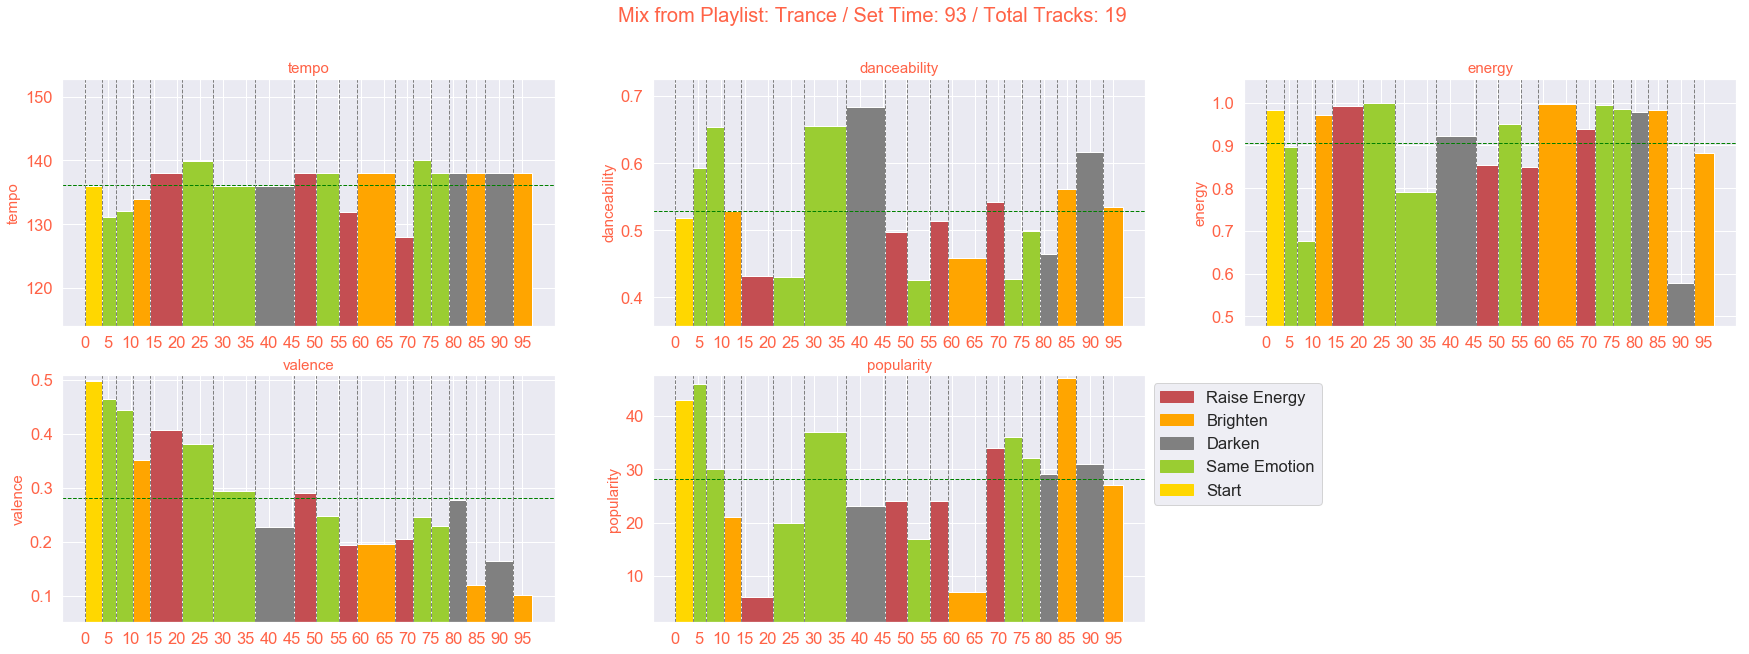

In [69]:
print('Set Mix Track Order: ')
print('\n')
for key, value in enumerate(set_track_name):
    print(key, value)

fig = plt.figure(figsize=(30,10))
# Plot title by Track name and Artist
fig.suptitle('Mix from Playlist: ' +str(playlist_name) +' / Set Time: ' +str(round(set_duration)) +' / Total Tracks: ' + str(len(tracks_order)), color='tomato', fontsize=20)
 
raise_energy = mpatches.Patch(color='r', label='Raise Energy')
brighten = mpatches.Patch(color='orange', label='Brighten')
darken = mpatches.Patch(color='grey', label='Darken')
same_emotion = mpatches.Patch(color='yellowgreen', label='Same Emotion')
start = mpatches.Patch(color='gold', label='Start')
handles = [raise_energy, brighten, darken, same_emotion, start]

for i in range(len(metrics)):
    ax = fig.add_subplot(2,3,i+1)
    ax = set_metrics_plot(metrics[i]) 
    
plt.legend(handles=handles, loc='best', bbox_to_anchor=(1, 1), ncol=1)
plt.show()

### Find a good intro track